# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.weightstats import ztest
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import folium
import os

# Tornadoes per State

During the data cleaning process, I explored tornado occurences per state to determine where I wanted to focus my analysis. To get a better visualization of this process, let's visualize the frequency of tornados in each state in 2020.

In [2]:
# import the 2020 tornado data
tornado_2020 = pd.read_csv('/Users/gregoryolson/Documents/Data Science CT/Capstone/Capstone_Tornado/Data/tornado_2020.csv')

In [3]:
# create lists of states and their corresponding tornado counts for 2020
state_list = tornado_2020['STATE_ABBR'].value_counts().index.tolist()
freq_list = tornado_2020['STATE_ABBR'].value_counts().tolist()

In [4]:
# create a dictionary from the 2 lists
state_freq = {}
for i in range(len(state_list)):
    state_freq[state_list[i]] = freq_list[i]
state_freq

{'MS': 96,
 'TX': 86,
 'AL': 78,
 'IL': 65,
 'GA': 64,
 'MN': 64,
 'SC': 54,
 'FL': 52,
 'LA': 49,
 'NC': 44,
 'AR': 42,
 'TN': 39,
 'OK': 39,
 'CO': 34,
 'IA': 31,
 'KY': 25,
 'SD': 23,
 'OH': 23,
 'ND': 22,
 'MO': 20,
 'WI': 20,
 'NE': 19,
 'MD': 17,
 'KS': 17,
 'IN': 14,
 'VA': 12,
 'NY': 10,
 'PA': 7,
 'CT': 6,
 'NM': 5,
 'CA': 4,
 'WY': 4,
 'DE': 4,
 'NJ': 4,
 'MT': 3,
 'MI': 3,
 'AZ': 2,
 'MA': 2,
 'NH': 2,
 'WA': 1,
 'ME': 1}

In [5]:
# load the shape of the zone (US states)
state_geo = os.path.join('/Users/gregoryolson/Documents/Data Science CT/Capstone/Capstone_Tornado/Data/', 'us-states.json')
 
# initialize the map:
m = folium.Map(location=[37, -102], zoom_start=4)
 
# customize the chloropleth map features:
m.choropleth(
 geo_data = state_geo,
 name = 'choropleth',
 data = state_freq,
 columns = ['State', 'Tornado Count'],
 key_on = 'feature.id',
 fill_color = 'YlGn',
 nan_fill_color = 'white',
 bins = 9,
 fill_opacity = 0.7,
 line_opacity = 0.2,
 legend_name = 'Number of Tornadoes 2020',
 highlight = True
)
folium.LayerControl().add_to(m)

m

/Users/gregoryolson/miniconda3/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


This visualization gives a nice idea of how many tornadoes occured during the first 8 months of 2020. It is interesting to see that the region of the country known as 'tornado alley' (including Oklahoma, Kansas, Nebraska, and the Dakotas) had fewer tornadoes than most of the southeastern states. Obviously this is just a quick snapshot, and a better historical visualization would look at a much larger timeframe. However, the above visualization does provide the best look at modern tornado occurrences, and being that severe weather events have ramped up as a result of climate change, the most recent data could provide the most valuable insights as to the predictability of these storms. 

In [6]:
# Save map to html
m.save('/Users/gregoryolson/Documents/Data Science CT/Capstone/Capstone_Tornado/Data/tornado_by_state_USA.html')

# Removing Unnecesary Columns

In [7]:
# import the merged dataframe from the Data Wrangling process
tornado_data = pd.read_csv('/Users/gregoryolson/Documents/Data Science CT/Capstone/Capstone_Tornado/Data/tornado_final.csv')

In [8]:
tornado_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 72 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   STATION              49999 non-null  int64  
 1   NAME                 49999 non-null  object 
 2   LATITUDE             49999 non-null  float64
 3   LONGITUDE            49999 non-null  float64
 4   ELEVATION            49999 non-null  float64
 5   DATE                 49999 non-null  object 
 6   DEWP                 46466 non-null  float64
 7   FRSHTT               49999 non-null  int64  
 8   GUST                 27188 non-null  float64
 9   MAX                  49946 non-null  float64
 10  MIN                  49948 non-null  float64
 11  MXSPD                46263 non-null  float64
 12  PRCP                 43757 non-null  float64
 13  SLP                  25518 non-null  float64
 14  STP                  39220 non-null  float64
 15  TEMP                 49999 non-null 

There are a lot of columns that are not needed for the analysis. By removing these columns, it will be easier to perform EDA and subsequent modeling

In [9]:
# drop narrative columns, as well as the absolute row number column
drop_cols = ['EVENT_NARRATIVE', 'EPISODE_NARRATIVE', 'ABSOLUTE_ROWNUMBER', 'DAMAGE_PROPERTY_NUM', 'DAMAGE_CROPS_NUM']
tornado_data.drop(drop_cols, axis=1, inplace=True)

Some columns are reference ID's which are type float64, but should be converted to strings

In [10]:
# convert ID columns to strings
tornado_data['EVENT_ID'] = tornado_data['EVENT_ID'].astype(str)
tornado_data['EPISODE_ID'] = tornado_data['EPISODE_ID'].astype(str)
tornado_data['CZ_FIPS'] = tornado_data['CZ_FIPS'].astype(str)
tornado_data['STATION'] = tornado_data['STATION'].astype(str)

# convert string nan values to type np.nan
tornado_data = tornado_data.replace('nan', np.nan)

There are a lot of begin/end columns, like Range, Lat, Lon, Azimuth, and Location. These are all quite redundant and perhaps just one set of these columns would be sufficient for potential reference later on. 

In [11]:
# explore the begin/end columns
cols = ['BEGIN_LAT', 'END_LAT', 'BEGIN_LON', 'END_LON', 'BEGIN_RANGE', 'END_RANGE', \
        'BEGIN_LOCATION', 'END_LOCATION', 'BEGIN_AZIMUTH', 'END_AZIMUTH']
begin_end = tornado_data.filter(items=cols)
begin_end.dropna().head()

BEGIN_LAT  END_LAT  BEGIN_LON  END_LON  BEGIN_RANGE  END_RANGE  \
44     31.0721  31.0912   -90.1828 -90.1014          1.0        1.0   
52     31.3955  31.4018   -90.5334 -90.5310          3.0        3.0   
366    31.0883  31.1025   -90.3515 -90.2867          1.0        0.0   
367    31.1158  31.1206   -90.2267 -90.2134          3.0        2.0   
719    31.2834  31.2845   -90.1802 -90.1777          3.0        3.0   

    BEGIN_LOCATION    END_LOCATION BEGIN_AZIMUTH END_AZIMUTH  
44           LEXIE            DAVO           SSW         ESE  
52       ARLINGTON       ARLINGTON            SE         ESE  
366        EMERALD  DYKES CROSSING           ENE         WNW  
367           MESA            MESA            SW         SSW  
719           ENON            ENON           ESE         ESE

In [12]:
# see if there are any interesting outlier for begin location
tornado_data.BEGIN_LOCATION.value_counts()

FEARNS SPGS     5
BAXTERVILLE     5
NOXAPATER       4
RAYMOND         3
WILLIAMSBURG    3
               ..
CALHOUN         1
SUN             1
GRANGE HALL     1
PACHUTA         1
HAMLET          1
Name: BEGIN_LOCATION, Length: 341, dtype: int64

Baxterville and Fearns Springs have had 5 tornadoes each the last 5 year. Even still, this doesn't seem too unusual.

In [13]:
# look at all of the values for begin range
tornado_data.BEGIN_RANGE.value_counts()

2.0     110
1.0     104
3.0      69
4.0      56
5.0      30
0.0      23
6.0      14
7.0       7
9.0       4
8.0       4
12.0      2
39.0      1
59.0      1
13.0      1
Name: BEGIN_RANGE, dtype: int64

The Range columns are very interesting. According to the NOAA documentation, they represent 'The distance to the nearest tenth of a mile, to the location referenced below.' However, every datapoint here is measured to the nearest whole mile. The outlying values (like 59.0) are interesting, but being that these values are non-continuous, they aren't very helpful, especially considering the newly-created Distance to Station column is much more precise.

In [14]:
# look at begin azimuth column values
tornado_data.BEGIN_AZIMUTH.value_counts()

SSW    44
W      40
NNW    30
N      30
WNW    29
SW     29
S      28
SSE    27
ENE    26
WSW    24
ESE    23
E      22
NW     21
NNE    20
SE     19
NE     14
Name: BEGIN_AZIMUTH, dtype: int64

Again, these are categorical, and don't offer much toward future modeling. Thus, I think it would fair to drop each pair of Range, Location, and Azimuth columns for the above stated reasons. The begin/end lat/lon columns can remain as the primary reference for location.

In [15]:
# drop range, location, and azimuth columns
tornado_data.drop(['BEGIN_RANGE', 'END_RANGE', 'BEGIN_LOCATION', 'END_LOCATION', \
                   'BEGIN_AZIMUTH', 'END_AZIMUTH'], axis=1, inplace=True)

In [16]:
pd.set_option('display.max_columns', None)
tornado_data.head()

STATION                                               NAME  LATITUDE  \
0  72235893919  MCCOMB PIKE COUNTY JOHN E LEWIS FIELD AIRPORT,...   31.1827   
1  72235893919  MCCOMB PIKE COUNTY JOHN E LEWIS FIELD AIRPORT,...   31.1827   
2  72235893919  MCCOMB PIKE COUNTY JOHN E LEWIS FIELD AIRPORT,...   31.1827   
3  72235893919  MCCOMB PIKE COUNTY JOHN E LEWIS FIELD AIRPORT,...   31.1827   
4  72235893919  MCCOMB PIKE COUNTY JOHN E LEWIS FIELD AIRPORT,...   31.1827   

   LONGITUDE  ELEVATION        DATE  DEWP  FRSHTT  GUST   MAX   MIN  MXSPD  \
0   -90.4708      125.9  2016-01-01  36.2   10000  20.0  52.0  41.0   12.0   
1   -90.4708      125.9  2016-01-02  31.7       0   NaN  51.1  39.9    8.9   
2   -90.4708      125.9  2016-01-03  35.2   10000   NaN  54.0  42.1    8.0   
3   -90.4708      125.9  2016-01-04  32.7       0  17.1  55.0  37.0   12.0   
4   -90.4708      125.9  2016-01-05  27.3       0   NaN  54.0  28.9    8.0   

   PRCP     SLP   STP  TEMP  VISIB  WDSP EVENT_ID CZ_NAME_STR BEGIN_DATE  \
0  0.08  1026.1  10.7  45.5    9.9   9.3      NaN         NaN        NaN   
1  0.01  1027.7  12.1  43.5   10.0   6.5      NaN         NaN        NaN   
2  0.00  1022.8   7.4  46.2   10.0   3.9      NaN         NaN        NaN   
3  0.00  1023.3   7.9  44.9   10.0   6.9      NaN         NaN        NaN   
4  0.00  1027.7  12.2  39.2   10.0   4.5      NaN         NaN        NaN   

   BEGIN_TIME EVENT_TYPE TOR_F_SCALE STATE_ABBR CZ_TIMEZONE EPISODE_ID  \
0         NaN        NaN         NaN        NaN         NaN        NaN   
1         NaN        NaN         NaN        NaN         NaN        NaN   
2         NaN        NaN         NaN        NaN         NaN        NaN   
3         NaN        NaN         NaN        NaN         NaN        NaN   
4         NaN        NaN         NaN        NaN         NaN        NaN   

  CZ_TYPE CZ_FIPS  WFO SOURCE  TOR_LENGTH  TOR_WIDTH  BEGIN_LAT  BEGIN_LON  \
0     NaN     NaN  NaN    NaN         NaN        NaN        NaN        NaN   
1     NaN     NaN  NaN    NaN         NaN        NaN        NaN        NaN   
2     NaN     NaN  NaN    NaN         NaN        NaN        NaN        NaN   
3     NaN     NaN  NaN    NaN         NaN        NaN        NaN        NaN   
4     NaN     NaN  NaN    NaN         NaN        NaN        NaN        NaN   

   END_LAT  END_LON DAY_BEFORE  DISTANCE_MILES     DEWP_3     DEWP_7  GUST_3  \
0      NaN      NaN        NaN             NaN  36.200000  36.200000    20.0   
1      NaN      NaN        NaN             NaN  33.950000  33.950000    20.0   
2      NaN      NaN        NaN             NaN  34.366667  34.366667    20.0   
3      NaN      NaN        NaN             NaN  33.200000  33.950000    17.1   
4      NaN      NaN        NaN             NaN  31.733333  32.620000    17.1   

   GUST_7      MAX_3      MAX_7      MIN_3  MIN_7    MXSPD_3    MXSPD_7  \
0   20.00  52.000000  52.000000  41.000000  41.00  12.000000  12.000000   
1   20.00  51.550000  51.550000  40.450000  40.45  10.450000  10.450000   
2   20.00  52.366667  52.366667  41.000000  41.00   9.633333   9.633333   
3   18.55  53.366667  53.025000  39.666667  40.00   9.633333  10.225000   
4   18.55  54.333333  53.220000  36.000000  37.78   9.333333   9.780000   

     PRCP_3  PRCP_7        SLP_3        SLP_7      STP_3      STP_7  \
0  0.080000  0.0800  1026.100000  1026.100000  10.700000  10.700000   
1  0.045000  0.0450  1026.900000  1026.900000  11.400000  11.400000   
2  0.030000  0.0300  1025.533333  1025.533333  10.066667  10.066667   
3  0.003333  0.0225  1024.600000  1024.975000   9.133333   9.525000   
4  0.000000  0.0180  1024.600000  1025.520000   9.166667  10.060000   

      TEMP_3     TEMP_7    VISIB_3   VISIB_7    WDSP_3    WDSP_7  
0  45.500000  45.500000   9.900000  9.900000  9.300000  9.300000  
1  44.500000  44.500000   9.950000  9.950000  7.900000  7.900000  
2  45.066667  45.066667   9.966667  9.966667  6.566667  6.566667  
3  44.866667  45.025000  10.000000  9.975000  5.766667  6.650000 

In [17]:
# check shape of the revised dataframe
tornado_data.shape

(49999, 61)

# Removing Redundant Weather Attributes

Along with the above columns that provided little relevance to the scope of this project, there are also other weather attributes that may potentially be redundant. There are 3 different wind attributes and 2 pressure attributes, so it would be nice to remove a few of these being that some have a large amount of missing values.

In [18]:
tornado_data.head()

STATION                                               NAME  LATITUDE  \
0  72235893919  MCCOMB PIKE COUNTY JOHN E LEWIS FIELD AIRPORT,...   31.1827   
1  72235893919  MCCOMB PIKE COUNTY JOHN E LEWIS FIELD AIRPORT,...   31.1827   
2  72235893919  MCCOMB PIKE COUNTY JOHN E LEWIS FIELD AIRPORT,...   31.1827   
3  72235893919  MCCOMB PIKE COUNTY JOHN E LEWIS FIELD AIRPORT,...   31.1827   
4  72235893919  MCCOMB PIKE COUNTY JOHN E LEWIS FIELD AIRPORT,...   31.1827   

   LONGITUDE  ELEVATION        DATE  DEWP  FRSHTT  GUST   MAX   MIN  MXSPD  \
0   -90.4708      125.9  2016-01-01  36.2   10000  20.0  52.0  41.0   12.0   
1   -90.4708      125.9  2016-01-02  31.7       0   NaN  51.1  39.9    8.9   
2   -90.4708      125.9  2016-01-03  35.2   10000   NaN  54.0  42.1    8.0   
3   -90.4708      125.9  2016-01-04  32.7       0  17.1  55.0  37.0   12.0   
4   -90.4708      125.9  2016-01-05  27.3       0   NaN  54.0  28.9    8.0   

   PRCP     SLP   STP  TEMP  VISIB  WDSP EVENT_ID CZ_NAME_STR BEGIN_DATE  \
0  0.08  1026.1  10.7  45.5    9.9   9.3      NaN         NaN        NaN   
1  0.01  1027.7  12.1  43.5   10.0   6.5      NaN         NaN        NaN   
2  0.00  1022.8   7.4  46.2   10.0   3.9      NaN         NaN        NaN   
3  0.00  1023.3   7.9  44.9   10.0   6.9      NaN         NaN        NaN   
4  0.00  1027.7  12.2  39.2   10.0   4.5      NaN         NaN        NaN   

   BEGIN_TIME EVENT_TYPE TOR_F_SCALE STATE_ABBR CZ_TIMEZONE EPISODE_ID  \
0         NaN        NaN         NaN        NaN         NaN        NaN   
1         NaN        NaN         NaN        NaN         NaN        NaN   
2         NaN        NaN         NaN        NaN         NaN        NaN   
3         NaN        NaN         NaN        NaN         NaN        NaN   
4         NaN        NaN         NaN        NaN         NaN        NaN   

  CZ_TYPE CZ_FIPS  WFO SOURCE  TOR_LENGTH  TOR_WIDTH  BEGIN_LAT  BEGIN_LON  \
0     NaN     NaN  NaN    NaN         NaN        NaN        NaN        NaN   
1     NaN     NaN  NaN    NaN         NaN        NaN        NaN        NaN   
2     NaN     NaN  NaN    NaN         NaN        NaN        NaN        NaN   
3     NaN     NaN  NaN    NaN         NaN        NaN        NaN        NaN   
4     NaN     NaN  NaN    NaN         NaN        NaN        NaN        NaN   

   END_LAT  END_LON DAY_BEFORE  DISTANCE_MILES     DEWP_3     DEWP_7  GUST_3  \
0      NaN      NaN        NaN             NaN  36.200000  36.200000    20.0   
1      NaN      NaN        NaN             NaN  33.950000  33.950000    20.0   
2      NaN      NaN        NaN             NaN  34.366667  34.366667    20.0   
3      NaN      NaN        NaN             NaN  33.200000  33.950000    17.1   
4      NaN      NaN        NaN             NaN  31.733333  32.620000    17.1   

   GUST_7      MAX_3      MAX_7      MIN_3  MIN_7    MXSPD_3    MXSPD_7  \
0   20.00  52.000000  52.000000  41.000000  41.00  12.000000  12.000000   
1   20.00  51.550000  51.550000  40.450000  40.45  10.450000  10.450000   
2   20.00  52.366667  52.366667  41.000000  41.00   9.633333   9.633333   
3   18.55  53.366667  53.025000  39.666667  40.00   9.633333  10.225000   
4   18.55  54.333333  53.220000  36.000000  37.78   9.333333   9.780000   

     PRCP_3  PRCP_7        SLP_3        SLP_7      STP_3      STP_7  \
0  0.080000  0.0800  1026.100000  1026.100000  10.700000  10.700000   
1  0.045000  0.0450  1026.900000  1026.900000  11.400000  11.400000   
2  0.030000  0.0300  1025.533333  1025.533333  10.066667  10.066667   
3  0.003333  0.0225  1024.600000  1024.975000   9.133333   9.525000   
4  0.000000  0.0180  1024.600000  1025.520000   9.166667  10.060000   

      TEMP_3     TEMP_7    VISIB_3   VISIB_7    WDSP_3    WDSP_7  
0  45.500000  45.500000   9.900000  9.900000  9.300000  9.300000  
1  44.500000  44.500000   9.950000  9.950000  7.900000  7.900000  
2  45.066667  45.066667   9.966667  9.966667  6.566667  6.566667  
3  44.866667  45.025000  10.000000  9.975000  5.766667  6.650000 

There are 3 different windspeed attributes: GUST (maximum wind gust), WDSP (mean windspeed), and MXSPD (maximum sustained windspeed). In Data Wrangling, I found that GUST had almost half of its rows containing missing values, while the MXSPD and WDSP each had less than 1 percent missing. If these columns are correlated, the GUST attribute could be completely removed from the data to avoid working with all of the missing values.

In [19]:
# look at correlation between GUST and WDSP
gust = np.array(tornado_data['GUST'].tolist())
wdsp = np.array(tornado_data['WDSP'].tolist())
nas = np.logical_or(np.isnan(gust), np.isnan(wdsp))
stats.pointbiserialr(gust[~nas], wdsp[~nas])

PointbiserialrResult(correlation=0.5704706328217001, pvalue=0.0)

In [20]:
# look at correlation between GUST and MAX
gust = np.array(tornado_data['GUST'].tolist())
mxspd = np.array(tornado_data['MXSPD'].tolist())
nas = np.logical_or(np.isnan(gust), np.isnan(mxspd))
stats.pointbiserialr(gust[~nas], mxspd[~nas])

PointbiserialrResult(correlation=0.8758629909757297, pvalue=0.0)

In [21]:
# look at correlation between MAX and WDSP
mxspd = np.array(tornado_data['MXSPD'].tolist())
wdsp = np.array(tornado_data['WDSP'].tolist())
nas = np.logical_or(np.isnan(mxspd), np.isnan(wdsp))
stats.pointbiserialr(mxspd[~nas], wdsp[~nas])

PointbiserialrResult(correlation=0.7400600715457932, pvalue=0.0)

Among the 3 comparisons, MXSPD and GUST had the strongest correlation of .88. This is strong enough evidence to suggest that the GUST column is redundant, and can be dropped. However, I will simply make note of this now, and drop the column later to preserve the data until the modeling phase.

The same analysis can be done to compare STP (mean station pressure) and SLP (mean sea level pressure). SLP has about half of its values missing, so it would be nice to remove this column as well.

In [22]:
# look at correlation between STP and SLP
stp = np.array(tornado_data['STP'].tolist())
slp = np.array(tornado_data['SLP'].tolist())
nas = np.logical_or(np.isnan(stp), np.isnan(slp))
stats.pointbiserialr(stp[~nas], slp[~nas])

PointbiserialrResult(correlation=0.7006520720462794, pvalue=0.0)

This correlation is just over .7, which is a strong correlation. This is a significant correlation, but again I am going to wait until the modeling phase to do any removal of rows.

In [23]:
# look at the number of missing values for each column of weather data
weather_data = tornado_data.iloc[:, : 18] + tornado_data.iloc[:, 39 :]
for column in weather_data:
    num = len(tornado_data.loc[tornado_data[column].isna()])
    print(column, '- ', num)

DATE -  0
DEWP -  3533
DEWP_3 -  3436
DEWP_7 -  3419
ELEVATION -  0
FRSHTT -  0
GUST -  22811
GUST_3 -  10866
GUST_7 -  5934
LATITUDE -  0
LONGITUDE -  0
MAX -  53
MAX_3 -  38
MAX_7 -  34
MIN -  51
MIN_3 -  28
MIN_7 -  14
MXSPD -  3736
MXSPD_3 -  3682
MXSPD_7 -  3645
NAME -  0
PRCP -  6242
PRCP_3 -  1884
PRCP_7 -  223
SLP -  24481
SLP_3 -  24377
SLP_7 -  24314
STATION -  0
STP -  10779
STP_3 -  8075
STP_7 -  6967
TEMP -  0
TEMP_3 -  0
TEMP_7 -  0
VISIB -  5123
VISIB_3 -  5070
VISIB_7 -  5041
WDSP -  3587
WDSP_3 -  3566
WDSP_7 -  3540


In [24]:
tornado_data.shape

(49999, 61)

# EDA

Before I can plot anything, I need to convert the target variable (whether or not a tornado occured) into a numeric value. Thus I will rename the EVENT_TYPE column to TORNADO, and I will replace values with 0's (no tornado) and 1's (tornado).

In [25]:
# rename column
tornado_data.rename(columns={'EVENT_TYPE': 'TORNADO'}, inplace=True)

In [26]:
# change column values 
tornado_data['TORNADO'].replace({'Tornado': 1, np.nan: 0}, inplace=True)

In [27]:
tornado_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 61 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   STATION         49999 non-null  object 
 1   NAME            49999 non-null  object 
 2   LATITUDE        49999 non-null  float64
 3   LONGITUDE       49999 non-null  float64
 4   ELEVATION       49999 non-null  float64
 5   DATE            49999 non-null  object 
 6   DEWP            46466 non-null  float64
 7   FRSHTT          49999 non-null  int64  
 8   GUST            27188 non-null  float64
 9   MAX             49946 non-null  float64
 10  MIN             49948 non-null  float64
 11  MXSPD           46263 non-null  float64
 12  PRCP            43757 non-null  float64
 13  SLP             25518 non-null  float64
 14  STP             39220 non-null  float64
 15  TEMP            49999 non-null  float64
 16  VISIB           44876 non-null  float64
 17  WDSP            46412 non-null 

In [28]:
# calculate percent of tornado occurences among the data
tornado_events = tornado_data.loc[tornado_data['TORNADO'] == 1]
p_tor = len(tornado_events)/len(tornado_data)
p_tor

0.008520170403408068

In [29]:
# use tornado_events dataframe to get a sense of the missing values of weather data when tornado occurred.
tornado_yes = tornado_events.iloc[:, : 18]
for column in tornado_yes:
    num = len(tornado_yes.loc[tornado_yes[column].isna()])
    print(column, '- ', num)

STATION -  0
NAME -  0
LATITUDE -  0
LONGITUDE -  0
ELEVATION -  0
DATE -  0
DEWP -  47
FRSHTT -  0
GUST -  115
MAX -  0
MIN -  2
MXSPD -  49
PRCP -  57
SLP -  209
STP -  129
TEMP -  0
VISIB -  47
WDSP -  49


In [30]:
# same thing as above, for 3-day and 7-day averages
tornado_yes2 = tornado_events.iloc[:, 39 :]
for column in tornado_yes2:
    num = len(tornado_yes2.loc[tornado_yes2[column].isna()])
    print(column, '- ', num)

DEWP_3 -  46
DEWP_7 -  46
GUST_3 -  81
GUST_7 -  54
MAX_3 -  0
MAX_7 -  0
MIN_3 -  0
MIN_7 -  0
MXSPD_3 -  49
MXSPD_7 -  49
PRCP_3 -  22
PRCP_7 -  2
SLP_3 -  209
SLP_7 -  209
STP_3 -  103
STP_7 -  86
TEMP_3 -  0
TEMP_7 -  0
VISIB_3 -  47
VISIB_7 -  47
WDSP_3 -  49
WDSP_7 -  49


Now let's look at the number of missing values when I subset on STP.

In [31]:
# create df stp that only contains rows where STP is not NaN
stp = tornado_events.dropna(subset=['STP'], axis=0)

In [32]:
# return the NaN value counts for each of the weather attributes with above subset
tornado_data_stp = stp.iloc[:, : 18]
for column in tornado_data_stp:
    num = len(tornado_data_stp.loc[tornado_data_stp[column].isna()])
    print(column, '- ', num)

STATION -  0
NAME -  0
LATITUDE -  0
LONGITUDE -  0
ELEVATION -  0
DATE -  0
DEWP -  0
FRSHTT -  0
GUST -  50
MAX -  0
MIN -  0
MXSPD -  0
PRCP -  43
SLP -  107
STP -  0
TEMP -  0
VISIB -  0
WDSP -  0


In [33]:
tornado_data_stp2 = stp.iloc[:, 39 :]
for column in tornado_data_stp2:
    num = len(tornado_data_stp2.loc[tornado_data_stp2[column].isna()])
    print(column, '- ', num)

DEWP_3 -  0
DEWP_7 -  0
GUST_3 -  26
GUST_7 -  4
MAX_3 -  0
MAX_7 -  0
MIN_3 -  0
MIN_7 -  0
MXSPD_3 -  0
MXSPD_7 -  0
PRCP_3 -  17
PRCP_7 -  2
SLP_3 -  107
SLP_7 -  107
STP_3 -  0
STP_7 -  0
TEMP_3 -  0
TEMP_7 -  0
VISIB_3 -  0
VISIB_7 -  0
WDSP_3 -  0
WDSP_7 -  0


A note: potentially could drop SLP and GUST and then fill in PRCP with either 0 or mean/median value

In [34]:
# let's drop SLP and GUST, along with their respective 3 and 7 day average columns
#stp = stp.drop(['SLP', 'SLP_3', 'SLP_7', 'GUST', 'GUST_3', 'GUST_7'], axis=1)

That means that 129 rows were dropped and as a result, there are now only 3 attributes (GUST, PRCP, and SLP) with missing values. This is interesting considering the first and third of these columns are being considered for dropping anyways. For now this is good to know and can be referenced further during the modeling process.

Let's return to the tornado_events data frame.

In [35]:
# look at tornado count by year
tornado_events['DATE'] = tornado_events['DATE'].astype('datetime64[ns]')
years = [2016, 2017, 2018, 2019, 2020]
counts = []
for year in years: 
    count = len(tornado_events.loc[tornado_events['DATE'].dt.year == year])
    counts.append(count)
    print(year, ':', count)

2016 : 53
2017 : 83
2018 : 57
2019 : 140
2020 : 93


<ipython-input-35-b7530c7c4255>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tornado_events['DATE'] = tornado_events['DATE'].astype('datetime64[ns]')


There seems to have been a lot of tornados in 2019 and 2020 (remember, the 2020 number represents only the first 8 months of the year). This is an interesting observation given the tornado-by-state visualization above and the decision to look at the most recent data. Perhaps these numbers are correlated to the total number of weather reports per year in the full dataset. 

To get a better sense of the expected number of tornadoes for September through December 2020, we can estimate using the average number of tornadoes in this time period for the other 4 years.

In [36]:
# count number of tornadoes from September to December, find average per year
tot_count = len(tornado_events[tornado_events['DATE'].dt.month.between(9,12)])
average_sept_dec = int(tot_count / 4)
average_sept_dec

18

In [37]:
# add the expected number of tornadoes for 2020 for sake of accurate visualization
counts[4] = counts[4] + average_sept_dec
counts

[53, 83, 57, 140, 111]

[Text(0, 0, '2016'),
 Text(1, 0, '2017'),
 Text(2, 0, '2018'),
 Text(3, 0, '2019'),
 Text(4, 0, '2020*')]

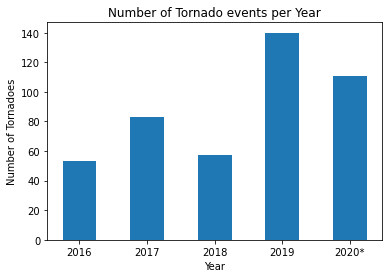

In [38]:
# visualize with a bar chart
labels = ['2016', '2017', '2018', '2019', '2020*']

x = np.arange(len(labels))  # the label locations
width = 0.5

fig, ax = plt.subplots()
rects = ax.bar(x, counts, width)

# add titles and custom x-axis tick labels
ax.set_xlabel('Year')
ax.set_ylabel('Number of Tornadoes')
ax.set_title('Number of Tornado events per Year')
ax.set_xticks(x)
ax.set_xticklabels(labels)

This reveals that perhaps 2019 and 2020 had more tornadoes even when accounting for the amount of data provided. Note that this chart looks at the percentage of days for all reporting stations that a tornado occured. 2019 saw more than double the amount of tornados compared to 2018.

In [39]:
# group the tornado events by season, in this case by 3 month intervals
s1 = 0 
s2 = 0
s3 = 0
s4 = 0

for s in tornado_events['DATE']:
    if s.month < 4:
        s1 += 1
    elif s.month < 7:
        s2 += 1
    elif s.month < 10:
        s3 += 1
    else:
        s4 += 1
        
print(s1, s2, s3, s4)

131 205 17 73


In [40]:
tot_count = len(tornado_events[tornado_events['DATE'].dt.month.between(9,9)])
average_sept = int(tot_count / 4)
average_sept

0

There was only 1 tornado in September from 2016-2019, so on average this averages to 0 per year. Thus we don't have to worry about adding any estimated tornadoes to the Jul-Sep range.

In [41]:
# need to do a similar thing for Oct-Dec that we did for 2020, since there aren't as many datapoints
tot_count = len(tornado_events[tornado_events['DATE'].dt.month.between(10,12)])
average_oct_dec = int(tot_count / 4)
average_oct_dec

18

In [42]:
# add the estimated tornadoes for Oct-Dec 2020
s4 += average_oct_dec

In [43]:
print(s1, s2, s3, s4)

131 205 17 91


[Text(0, 0, 'Jan-Mar'),
 Text(1, 0, 'Apr-Jun'),
 Text(2, 0, 'Jul-Sep'),
 Text(3, 0, 'Oct-Dec*')]

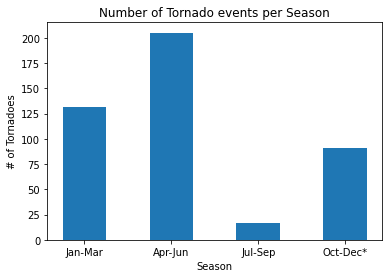

In [44]:
# plot a bar chart of the tornado events by season
bin_labels = ['Jan-Mar', 'Apr-Jun', 'Jul-Sep', 'Oct-Dec*']
bins = [s1, s2, s3, s4]

x = np.arange(len(bin_labels))  # the label locations
width = 0.5

fig, ax = plt.subplots()
rects = ax.bar(x, bins, width, label='# Tornadoes')

# add titles and custom x-axis tick labels
ax.set_ylabel('# of Tornadoes')
ax.set_xlabel('Season')
ax.set_title('Number of Tornado events per Season')
ax.set_xticks(x)
ax.set_xticklabels(bin_labels)

This chart shows a major discrepency in the number of tornadoes based on the seson. April to June saw over 200 tornadoes while July to September yielded only 17, a major difference. Note that this figure is skewed based on the grouping of months that I chose, and would look slighlty different if I chose different 3 month increments. Nonetheless, it shows that general idea that tornadoes are far more or less likely depending upon the month of the year.

<AxesSubplot:>

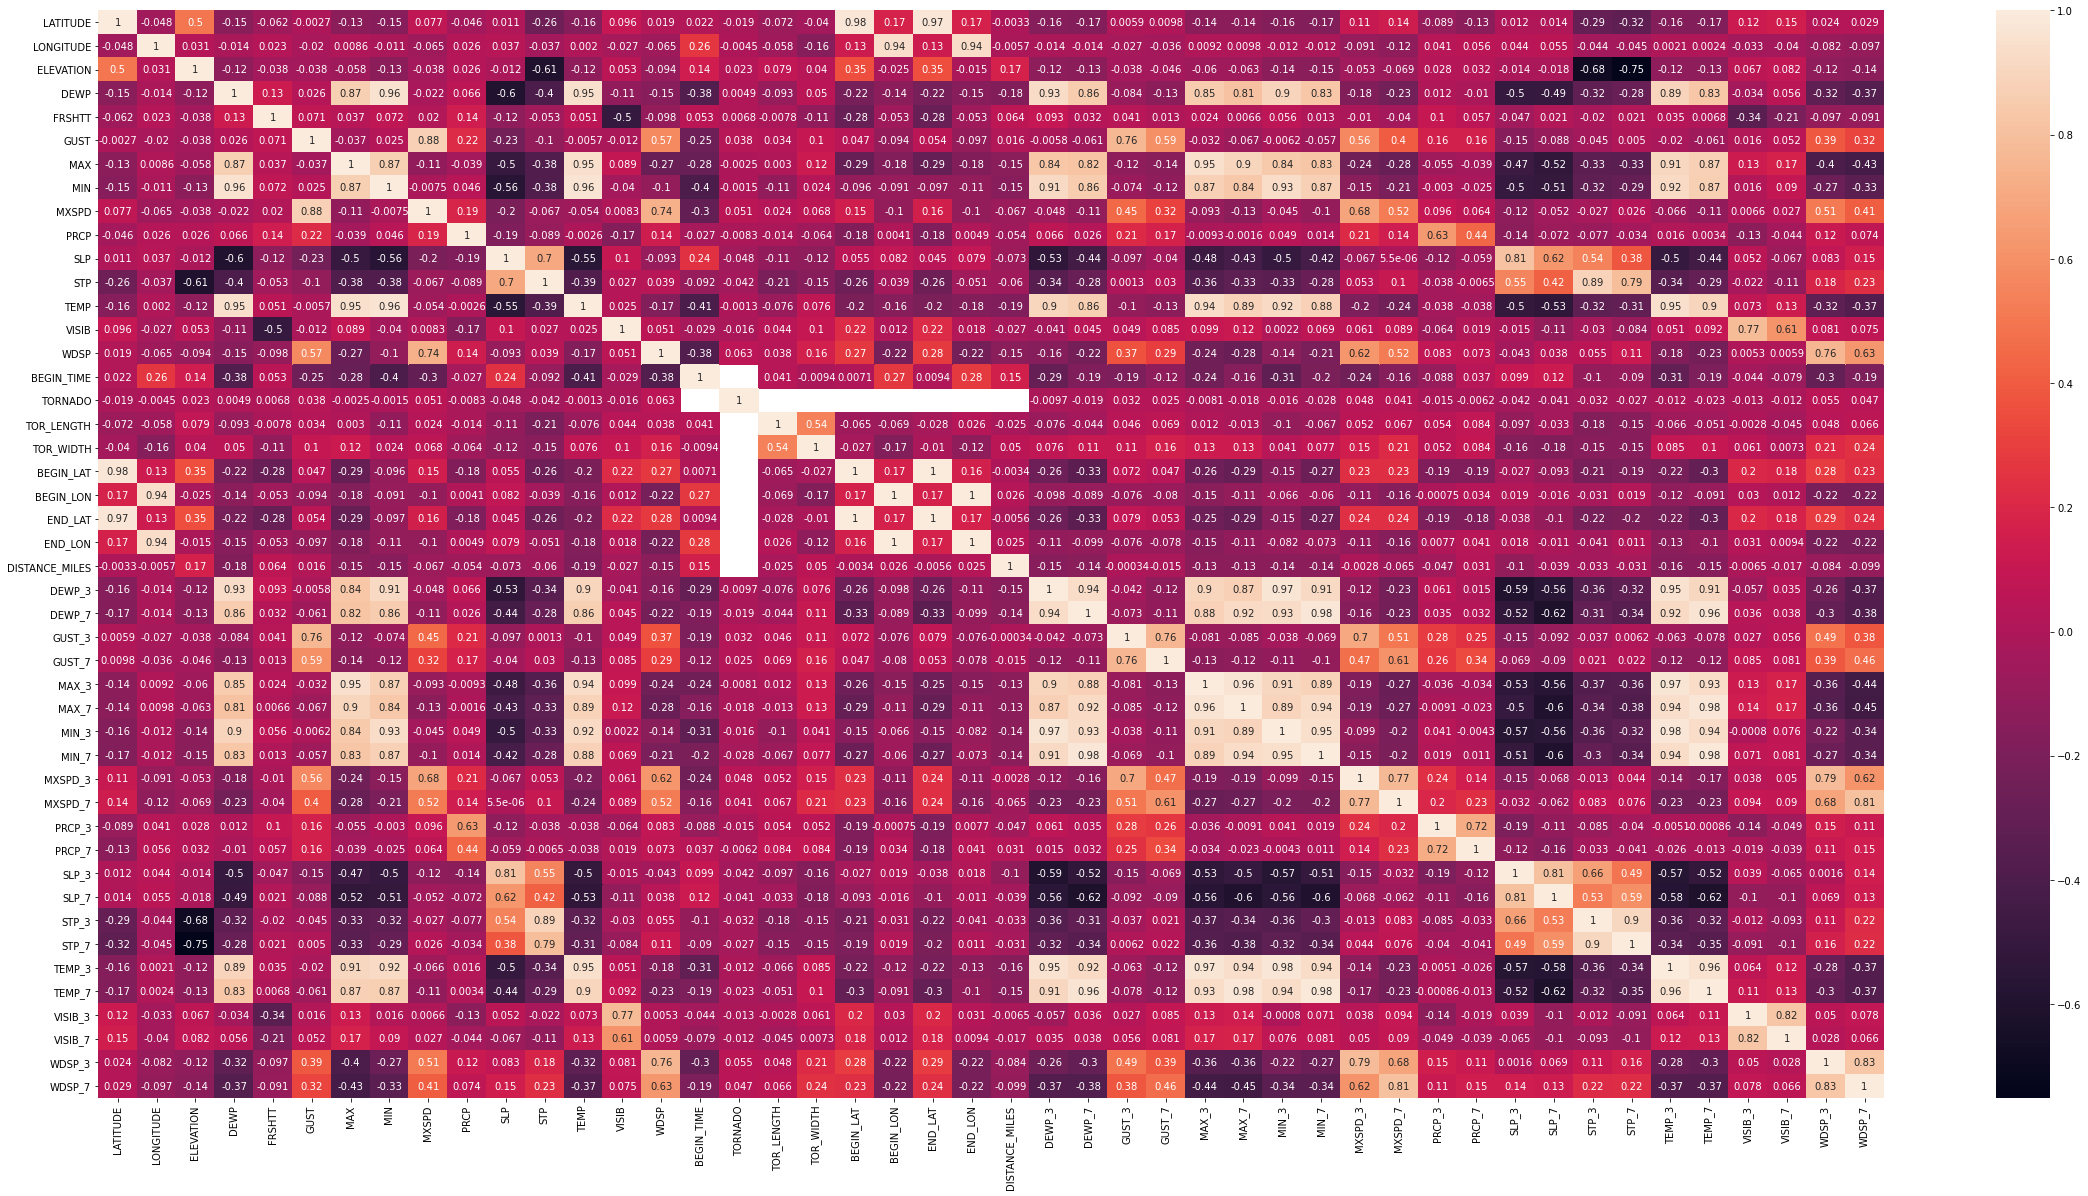

In [45]:
# plot heatmap of all attributes
plt.figure(figsize=(40,20))
sns.heatmap(tornado_data.corr(), annot=True)

In [46]:
# now choose only the weather attributes
arr = [6,8,9,10,11,12,13,14,15,16,17,22]
weather_data = tornado_data.iloc[:,arr]

<AxesSubplot:>

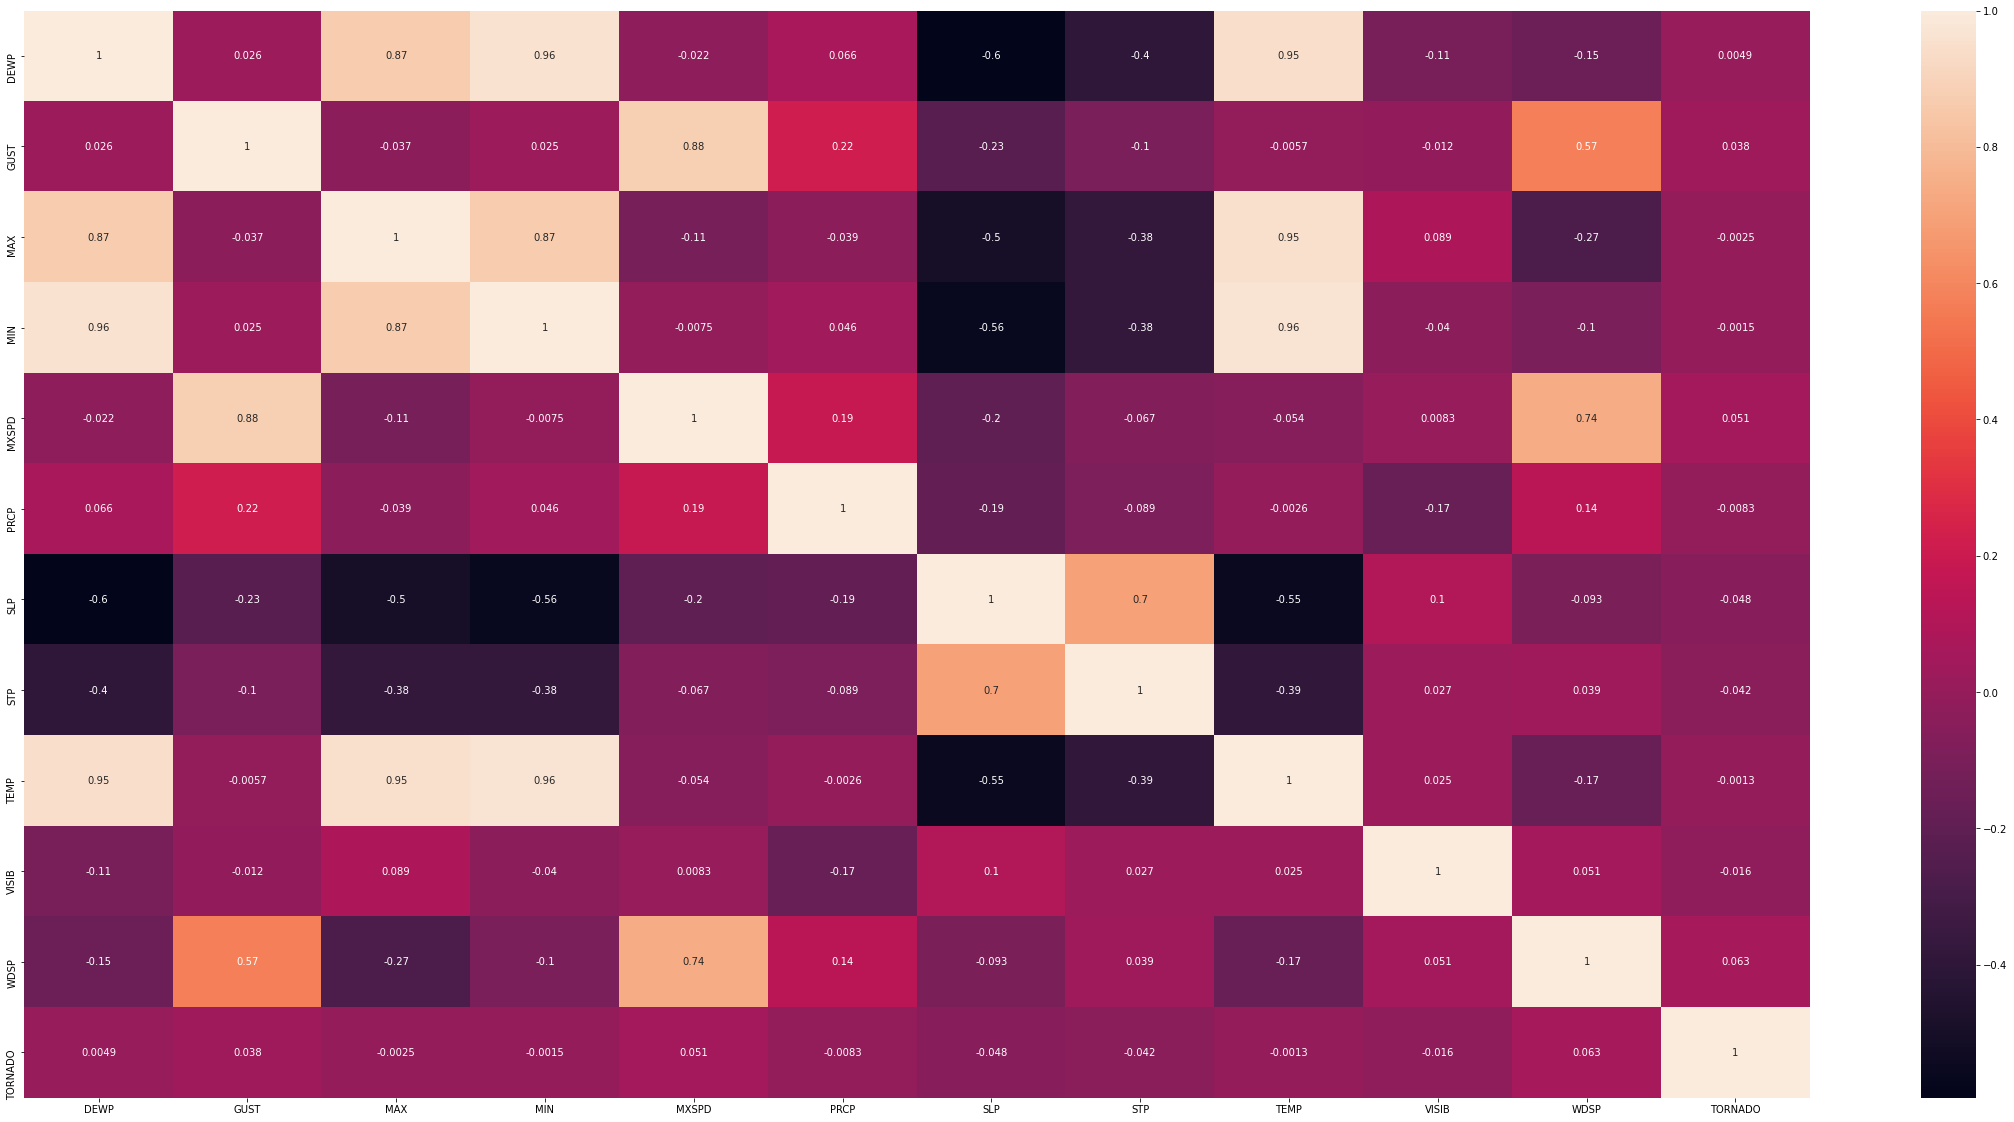

In [47]:
# plot heatmap for just the weather attributes to get a better look at potential correlations
plt.figure(figsize=(40,20))
sns.heatmap(weather_data.corr(), annot=True)

Some observations: temperature and dewpoint are very much all correlated, which makes sense since dewpoint uses temperature in its calculation. There's a moderately strong negative correlation between atmospheric pressure and elevation. Also, as seen earlier, the three wind and two pressure attributes are very strongly correlated. Looking at the target variable, there don't seem to be any strong correlations. 

<AxesSubplot:>

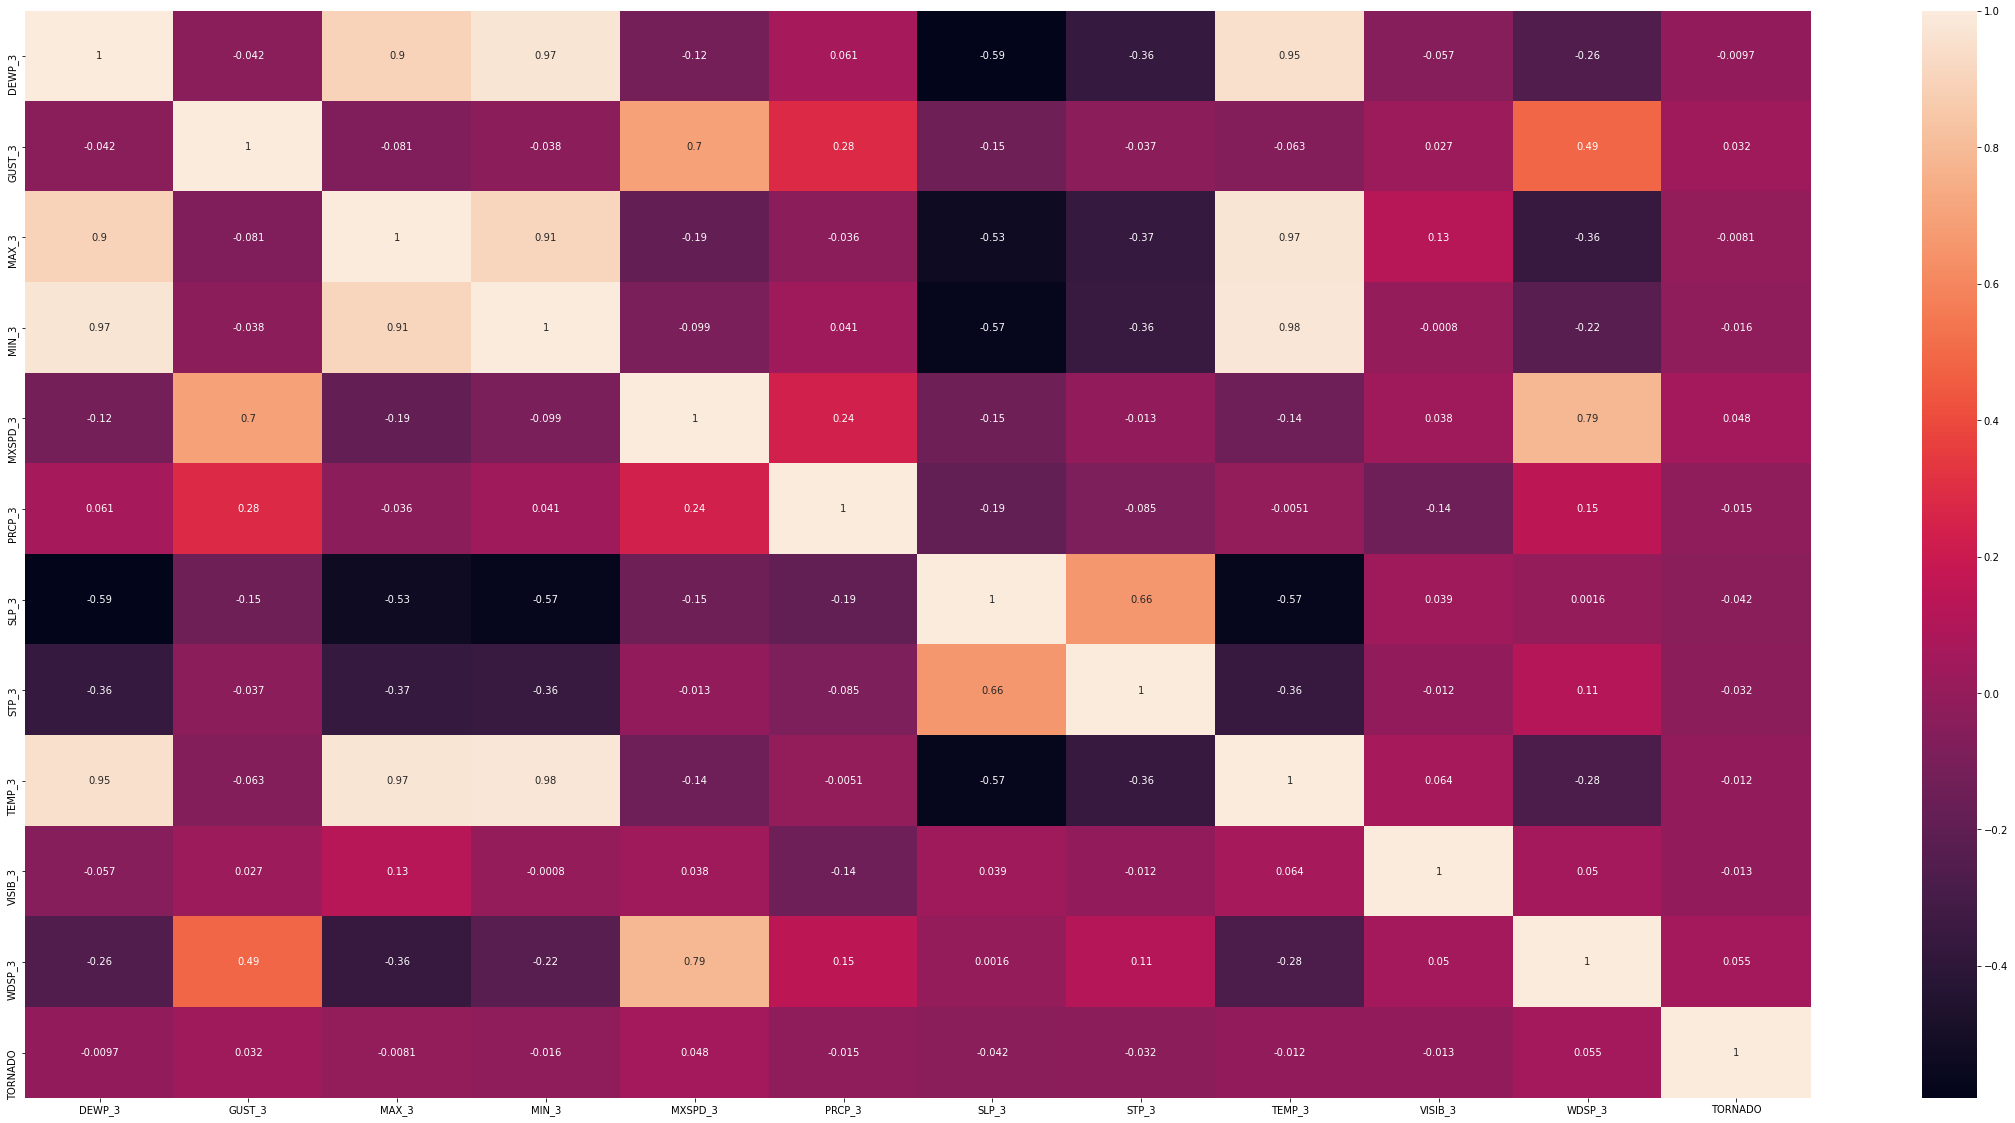

In [48]:
# plot heatmap for the 3-day average of weather attributes
arr2 = [39,41,43,45,47,49,51,53,55,57,59,22]
weather_data2 = tornado_data.iloc[:,arr2]
plt.figure(figsize=(40,20))
sns.heatmap(weather_data2.corr(), annot=True)

<AxesSubplot:>

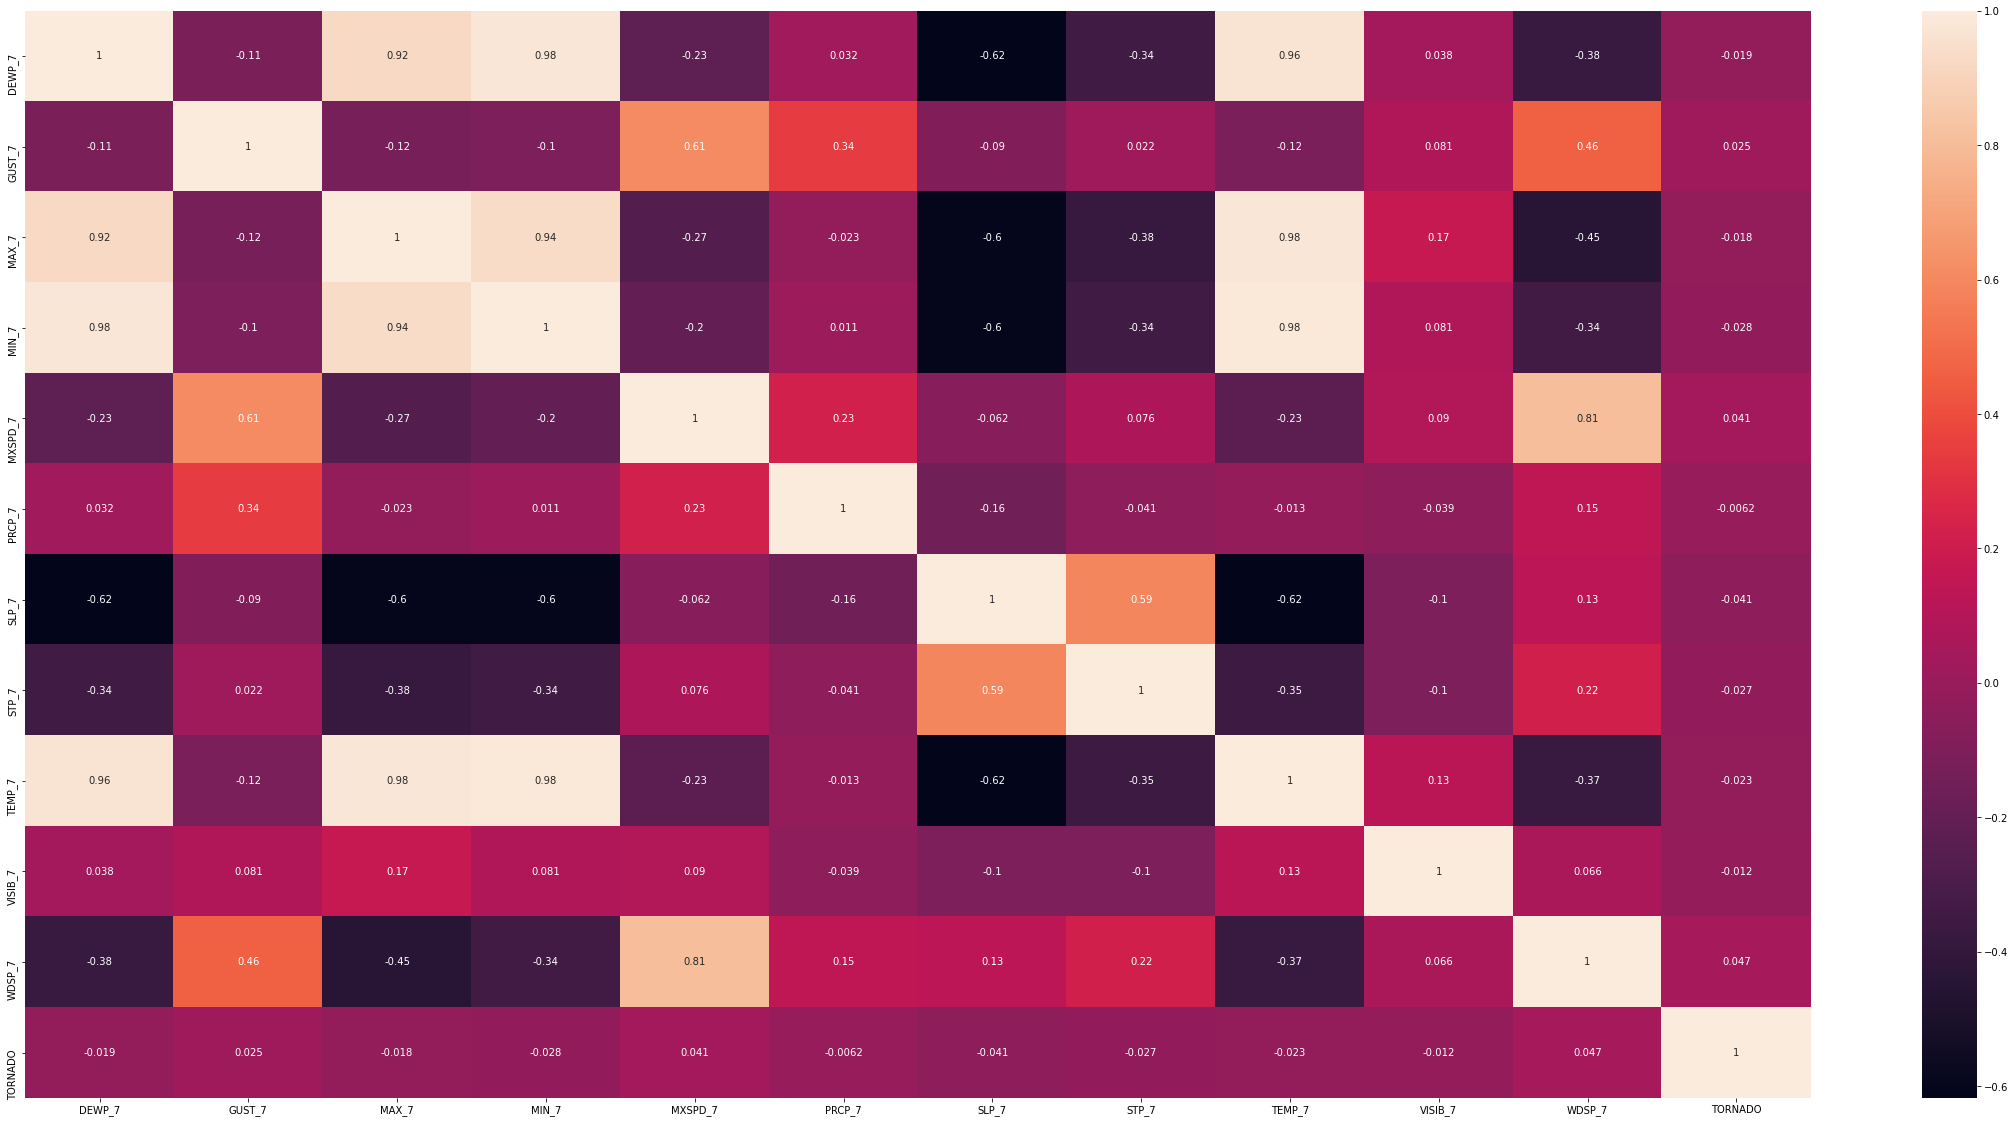

In [49]:
# plot heatmap for the 7-day average of weather attributes
arr3 = [40,42,44,46,48,50,52,54,56,58,60,22]
weather_data3 = tornado_data.iloc[:,arr3]
plt.figure(figsize=(40,20))
sns.heatmap(weather_data3.corr(), annot=True)

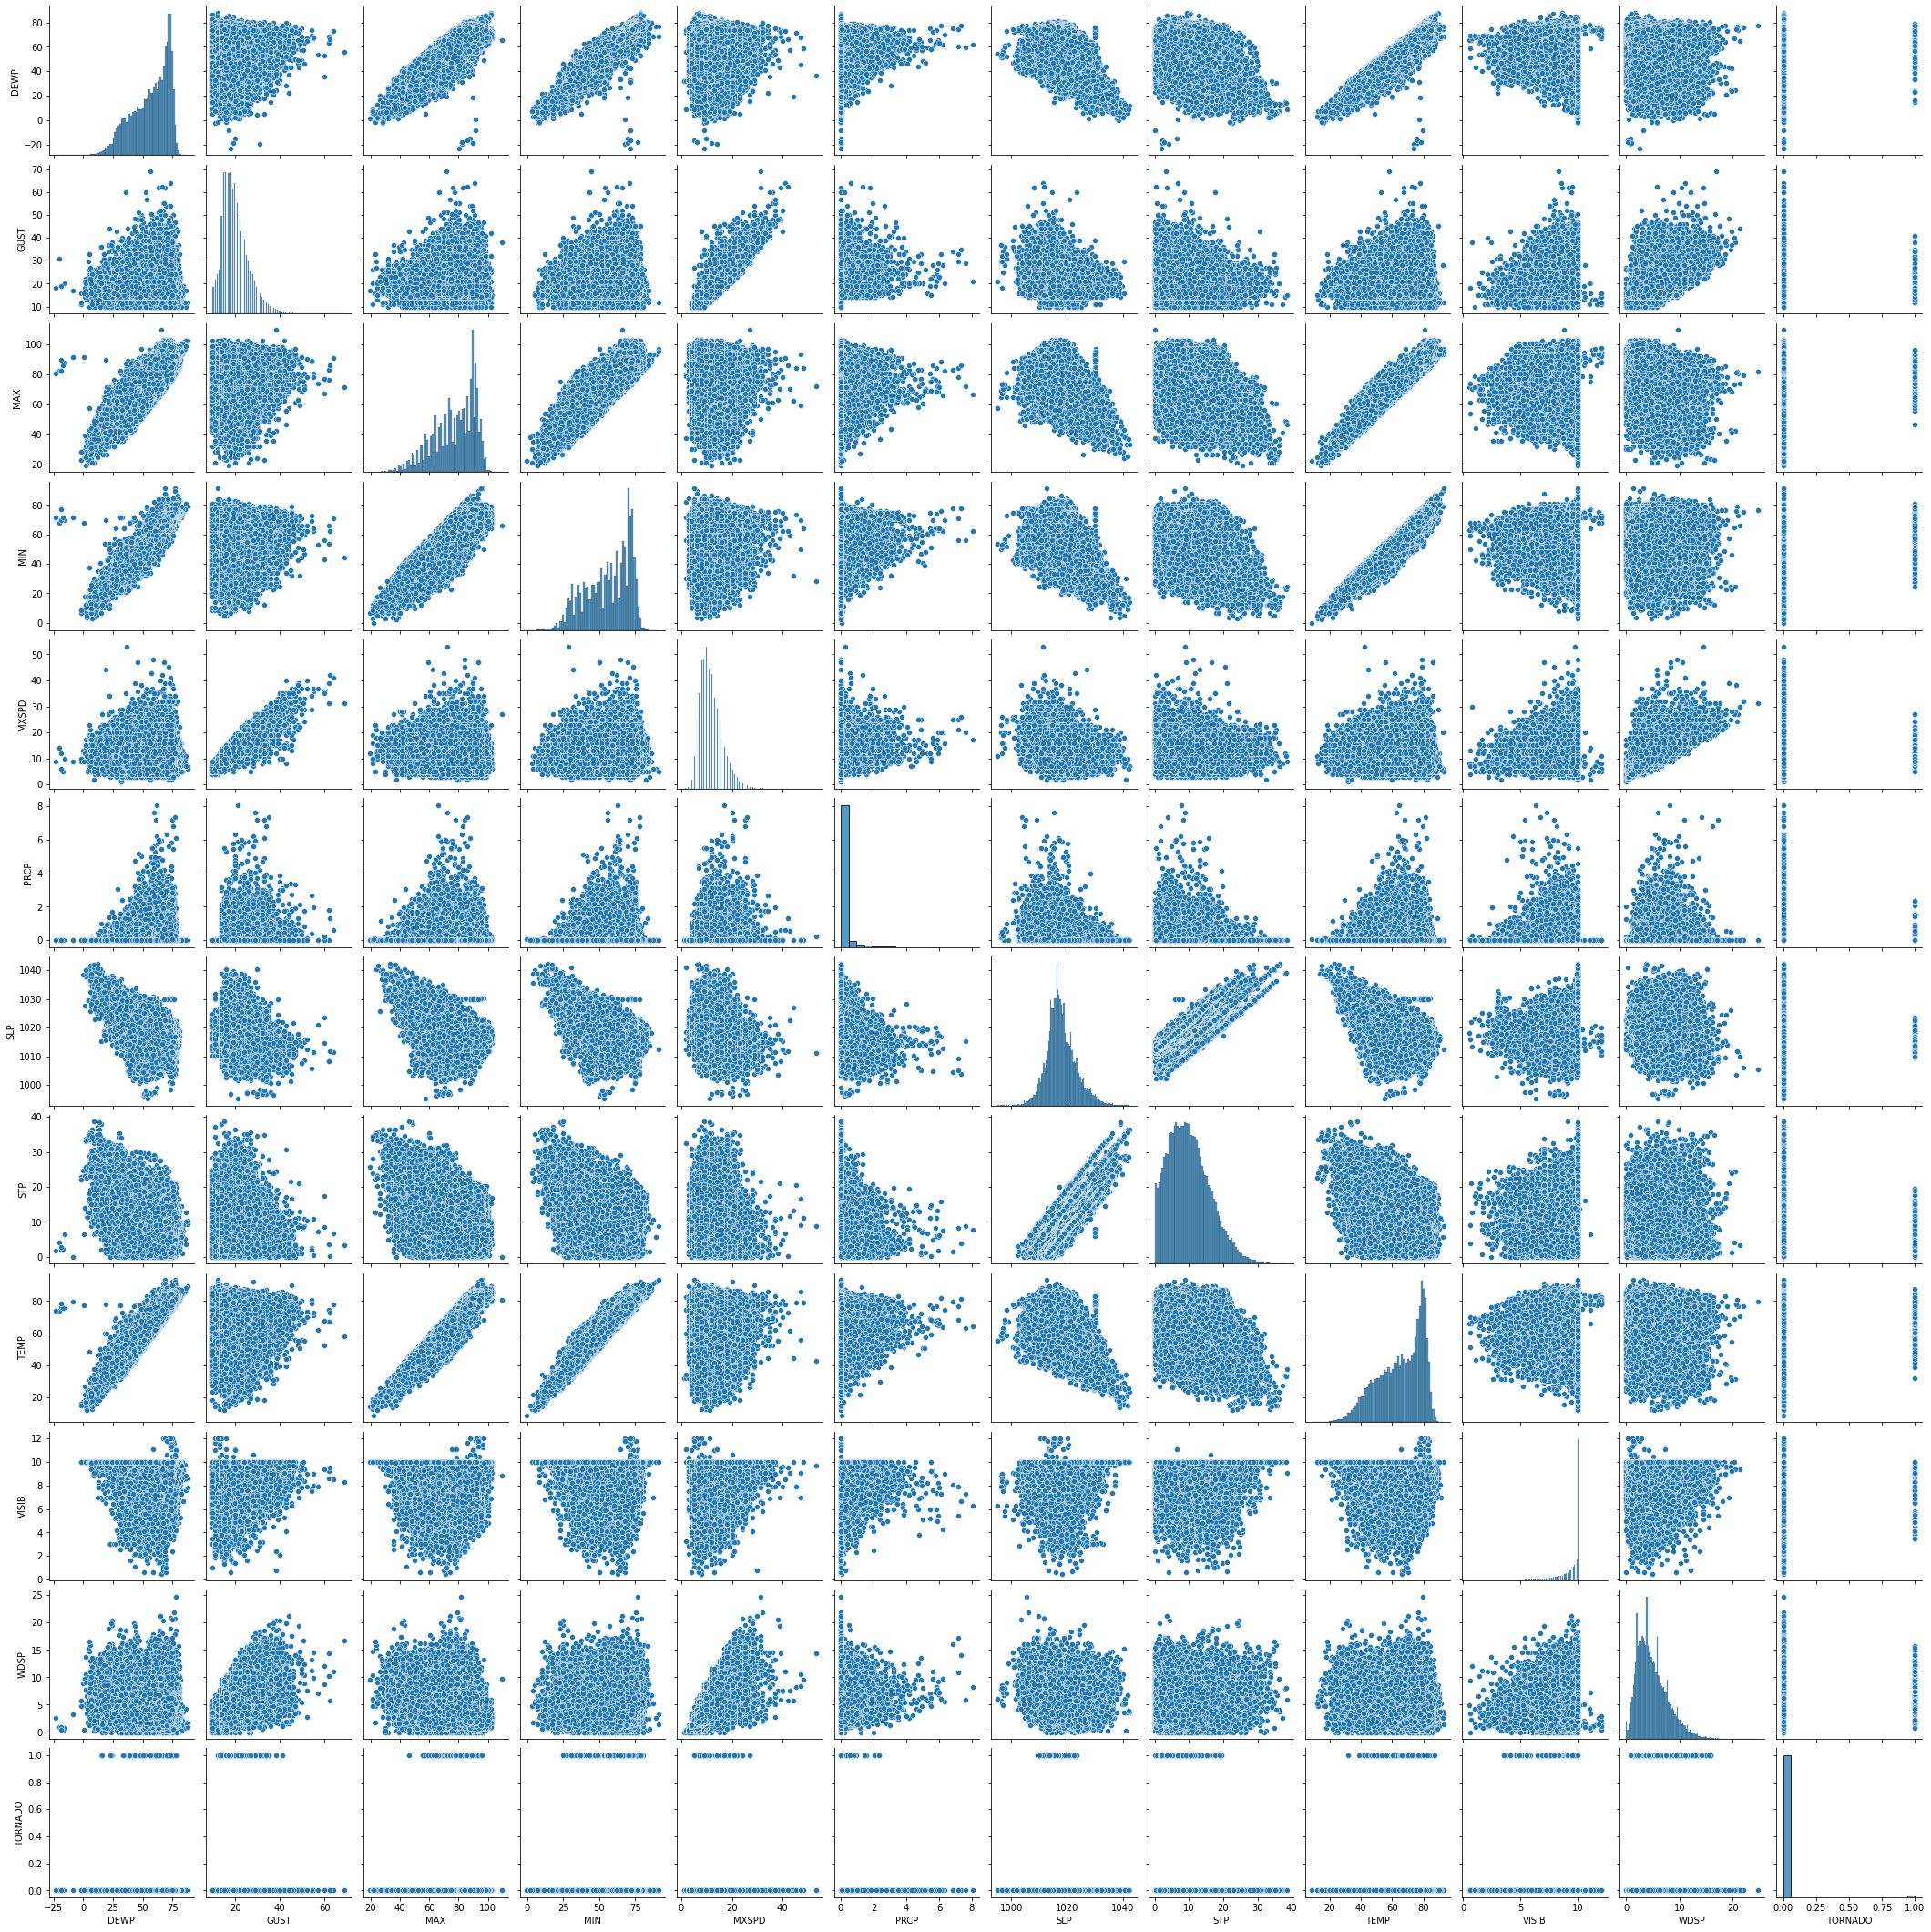

In [50]:
# look at scatter plots of all combinations of the weather data
sns.pairplot(weather_data)

The tornado column is not visually appealing, but that's because there are only 2 possible values. This visualization is very helpful in getting a good sense of the weather patterns on days where tornadoes did occur. Just a quick glance reveals that the days before a tornado have a high Dewpoint, high Temperature, low Standard atmospheric pressure, and relatively high visibility.

Text(0.5, 1.0, 'Minimum Temperature vs. Dewpoint')

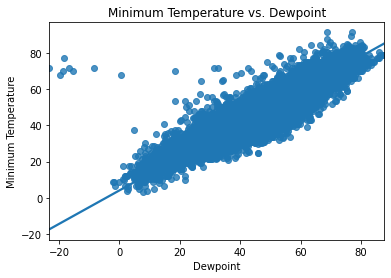

In [51]:
# plot dewpoint vs minimum temperature to get a closer look at the outliers
sns.regplot(x='DEWP', y='MIN', data=tornado_data)
plt.xlabel('Dewpoint')
plt.ylabel('Minimum Temperature')
plt.title('Minimum Temperature vs. Dewpoint')

Minimum temperature and dewpoint have a very strong correlation (0.96) and this can be seen in the above histogram. It's interesting to note the outlier values, where dewpoint is -20 and min temperature is about 70.

In [52]:
# see how many dewpoints values are negative
tornado_data.DEWP[tornado_data['DEWP'] < 0].count()

11

In [53]:
# look at the dewpoints with the lowest values and their associated minimum temperatures 
tornado_data.filter(['DEWP', 'MIN']).sort_values(by=['DEWP', 'MIN'], ascending=True).head(20)

DEWP   MIN
42751 -23.2  71.6
42747 -19.8  68.0
42748 -18.8  69.8
42750 -18.4  77.0
42749 -16.7  71.6
42746 -15.4  69.8
42752  -8.3  71.6
9970   -2.1   8.6
37328  -1.8   8.6
30659  -1.6   6.8
13208  -0.2   9.0
42745   0.5  68.0
9969    1.1  10.4
37327   1.1  17.6
13209   1.5  10.0
30658   1.7   6.8
13207   1.7  12.0
16527   1.9  12.2
18216   2.4  12.0
38899   2.4  12.2

It looks like rows 42745-42751 have very low dewpoints and very high low temperatures. This is not a usual pattern, so let's look at these rows closer.

In [54]:
tornado_data.iloc[42744:42755]

STATION                           NAME  LATITUDE  LONGITUDE  \
42744  72076900275  GEORGE M BRYAN AIRPORT, MS US    33.433    -88.849   
42745  72076900275  GEORGE M BRYAN AIRPORT, MS US    33.433    -88.849   
42746  72076900275  GEORGE M BRYAN AIRPORT, MS US    33.433    -88.849   
42747  72076900275  GEORGE M BRYAN AIRPORT, MS US    33.433    -88.849   
42748  72076900275  GEORGE M BRYAN AIRPORT, MS US    33.433    -88.849   
42749  72076900275  GEORGE M BRYAN AIRPORT, MS US    33.433    -88.849   
42750  72076900275  GEORGE M BRYAN AIRPORT, MS US    33.433    -88.849   
42751  72076900275  GEORGE M BRYAN AIRPORT, MS US    33.433    -88.849   
42752  72076900275  GEORGE M BRYAN AIRPORT, MS US    33.433    -88.849   
42753  72076900275  GEORGE M BRYAN AIRPORT, MS US    33.433    -88.849   
42754  72076900275  GEORGE M BRYAN AIRPORT, MS US    33.433    -88.849   

       ELEVATION        DATE  DEWP  FRSHTT  GUST   MAX   MIN  MXSPD  PRCP  \
42744      101.2  2019-07-04  18.5       0   NaN  89.6  69.8    6.0   0.0   
42745      101.2  2019-07-05   0.5       0  15.9  91.4  68.0    8.9   0.0   
42746      101.2  2019-07-06 -15.4       0  20.0  87.8  69.8    9.9   0.0   
42747      101.2  2019-07-07 -19.8       0  31.1  82.4  68.0   14.0   0.0   
42748      101.2  2019-07-08 -18.8       0  19.0  89.6  69.8   12.0   0.0   
42749      101.2  2019-07-09 -16.7       0   NaN  86.0  71.6    5.1   0.0   
42750      101.2  2019-07-10 -18.4       0   NaN  82.4  77.0    6.0   0.0   
42751      101.2  2019-07-11 -23.2       0  18.1  80.6  71.6    8.9   0.0   
42752      101.2  2019-07-12  -8.3       0  17.1  91.4  71.6    8.9   0.0   
42753      101.2  2019-07-13  31.2       0  15.9  82.4  71.6   11.1   0.0   
42754      101.2  2019-07-14  70.1       0  18.1  73.4  69.8    8.9   0.0   

       SLP  STP  TEMP  VISIB  WDSP EVENT_ID CZ_NAME_STR BEGIN_DATE  \
42744  NaN  4.7  78.0    NaN   1.7      NaN         NaN        NaN   
42745  NaN  6.6  77.3    NaN   0.5      NaN         NaN        NaN   
42746  NaN  6.5  75.5    NaN   0.8      NaN         NaN        NaN   
42747  NaN  4.1  73.9    NaN   0.9      NaN         NaN        NaN   
42748  NaN  2.1  76.1    NaN   1.0      NaN         NaN        NaN   
42749  NaN  2.2  76.0    NaN   0.3      NaN         NaN        NaN   
42750  NaN  2.8  78.5    NaN   0.4      NaN         NaN        NaN   
42751  NaN  1.9  74.0    NaN   2.6      NaN         NaN        NaN   
42752  NaN  0.0  79.9    NaN   3.3      NaN         NaN        NaN   
42753  NaN  2.9  77.3    NaN   4.2      NaN         NaN        NaN   
42754  NaN  7.6  71.6    NaN   2.3      NaN         NaN        NaN   

       BEGIN_TIME  TORNADO TOR_F_SCALE STATE_ABBR CZ_TIMEZONE EPISODE_ID  \
42744         NaN        0         NaN        NaN         NaN        NaN   
42745         NaN        0         NaN        NaN         NaN        NaN   
42746         NaN        0         NaN        NaN         NaN        NaN   
42747         NaN        0         NaN        NaN         NaN        NaN   
42748         NaN        0         NaN        NaN         NaN        NaN   
42749         NaN        0         NaN        NaN         NaN        NaN   
42750         NaN        0         NaN        NaN         NaN        NaN   
42751         NaN        0         NaN        NaN         NaN        NaN   
42752         NaN        0         NaN        NaN         NaN        NaN   
42753         NaN        0         NaN        NaN         NaN        NaN   
42754         NaN        0         NaN        NaN         NaN        NaN   

      CZ_TYPE CZ_FIPS  WFO SOURCE  TOR_LENGTH  TOR_WIDTH  BEGIN_LAT  \
42744     NaN     NaN  NaN    NaN         NaN        NaN        NaN   
42745     NaN     NaN  NaN    NaN         NaN        NaN        NaN   
42746     NaN     NaN  NaN    NaN         NaN        NaN        NaN   
42747     NaN     NaN  NaN    NaN         NaN        NaN        NaN   
42748     NaN     NaN  NaN    NaN         NaN        NaN        NaN   
42749     NaN    

After researching Dewpoint, which is calculated using air temperature and relative humidity, these negative values are possible (for example, a dewpoint of -23.2 and temperature of 71.6 would require a relative humidity of about 1.8). Although this is possible, it is most likely a result of an error in data recording, especially considering all of these values occur in succession in a week in July at the same station. Thus, I will remove these seven values being that the chance of these being accurate measurements is almost 0. 

In [55]:
# set these 7 values to np.nan
tornado_data.loc[42745:42753, 'DEWP'] = np.nan

Text(0.5, 1.0, 'Minimum Temperature vs. Dewpoint')

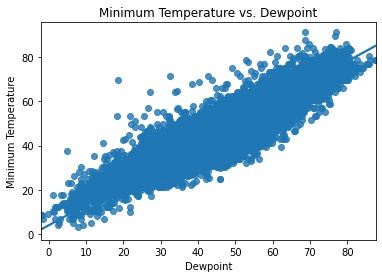

In [56]:
# plot the new Min vs DEWP plot without outliers
sns.regplot(x='DEWP', y='MIN', data=tornado_data)
plt.xlabel('Dewpoint')
plt.ylabel('Minimum Temperature')
plt.title('Minimum Temperature vs. Dewpoint')

This distribution looks much more evenly distributed.

Now let's look at boxplots of some of the above columns that showed discrepencies in whether or not a tornado occured on that day.

Text(0.5, 1.0, '7-day Average Temperature')

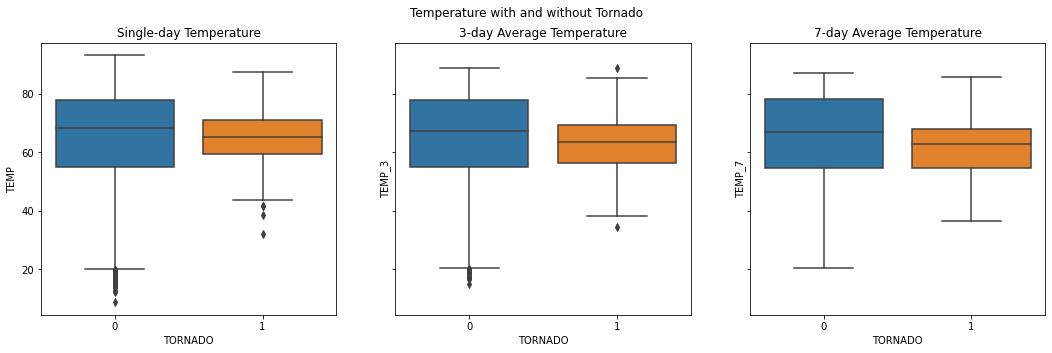

In [57]:
# compare boxplots of temperature based on whether a tornado occured
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Temperature with and without Tornado')

sns.boxplot(ax=axes[0], x='TORNADO', y='TEMP', data=tornado_data)
axes[0].set_title('Single-day Temperature')

sns.boxplot(ax=axes[1], x='TORNADO', y='TEMP_3', data=tornado_data)
axes[1].set_title('3-day Average Temperature')

sns.boxplot(ax=axes[2], x='TORNADO', y='TEMP_7', data=tornado_data)
axes[2].set_title('7-day Average Temperature')

In [58]:
# calculate means for temperature with and without tornado
mean_temp = tornado_data['TEMP_7'].loc[tornado_data['TORNADO'] == 0].mean()
mean_tempt = tornado_data['TEMP_7'].loc[tornado_data['TORNADO'] == 1].mean()

In [59]:
# convert dfs to arrays
x_temp = np.array(tornado_data['TEMP_7'].loc[tornado_data['TORNADO'] == 0].dropna())
y_temp = np.array(tornado_data['TEMP_7'].loc[tornado_data['TORNADO'] == 1].dropna())

In [60]:
# perform z-test on sample
ztest(y_temp, value=mean_temp)

(-6.942707641482133, 3.84654957447465e-12)

Text(0.5, 1.0, '7-day Average STP')

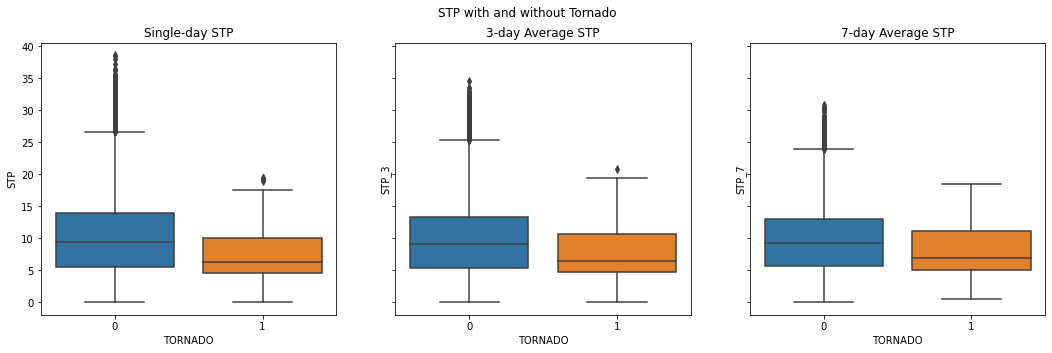

In [61]:
# compare boxplots of atmospheric pressure based on whether a tornado occured
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('STP with and without Tornado')

sns.boxplot(ax=axes[0], x='TORNADO', y='STP', data=tornado_data)
axes[0].set_title('Single-day STP')

sns.boxplot(ax=axes[1], x='TORNADO', y='STP_3', data=tornado_data)
axes[1].set_title('3-day Average STP')

sns.boxplot(ax=axes[2], x='TORNADO', y='STP_7', data=tornado_data)
axes[2].set_title('7-day Average STP')

In [62]:
# calculate means for visibility with and without tornado
mean_stp = tornado_data['STP_7'].loc[tornado_data['TORNADO'] == 0].mean()
mean_stpt = tornado_data['STP_7'].loc[tornado_data['TORNADO'] == 1].mean()

In [63]:
# convert dfs to arrays
x_stp = np.array(tornado_data['STP_7'].loc[tornado_data['TORNADO'] == 0].dropna())
y_stp = np.array(tornado_data['STP_7'].loc[tornado_data['TORNADO'] == 1].dropna())

In [64]:
# perform z-test on sample
ztest(y_stp, value=mean_stp)

(-6.85260068639697, 7.2519309014654465e-12)

Text(0.5, 1.0, '7-day Average VISIB')

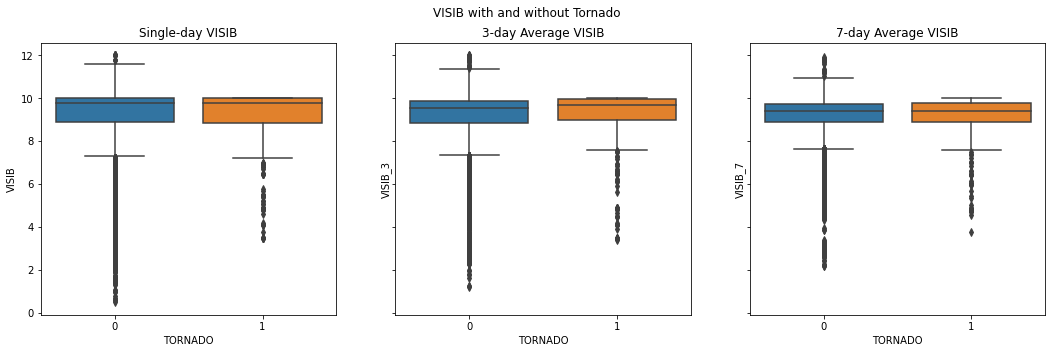

In [65]:
# compare boxplots of visibility based on whether a tornado occured
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('VISIB with and without Tornado')

sns.boxplot(ax=axes[0], x='TORNADO', y='VISIB', data=tornado_data)
axes[0].set_title('Single-day VISIB')

sns.boxplot(ax=axes[1], x='TORNADO', y='VISIB_3', data=tornado_data)
axes[1].set_title('3-day Average VISIB')

sns.boxplot(ax=axes[2], x='TORNADO', y='VISIB_7', data=tornado_data)
axes[2].set_title('7-day Average VISIB')

In [66]:
# calculate means for visibility with and without tornado
mean_visib = tornado_data['VISIB_7'].loc[tornado_data['TORNADO'] == 0].mean()
mean_visibt = tornado_data['VISIB_7'].loc[tornado_data['TORNADO'] == 1].mean()

In [67]:
# convert dfs to arrays
x_visib = np.array(tornado_data['VISIB_7'].loc[tornado_data['TORNADO'] == 0].dropna())
y_visib = np.array(tornado_data['VISIB_7'].loc[tornado_data['TORNADO'] == 1].dropna())

In [68]:
# perform z-test on sample
ztest(y_visib, value=mean_visib)

(-1.8934133639747548, 0.058302919592336855)

The data definitely isn't normally distributed. What should I do?

Text(0.5, 1.0, '7-day Average DEWP')

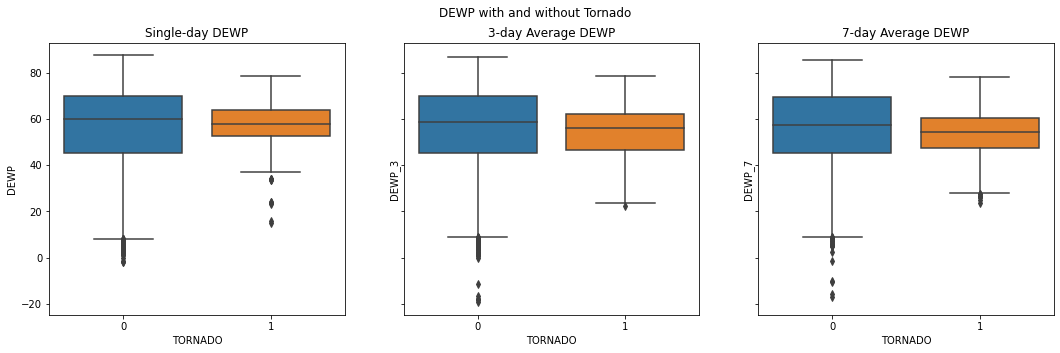

In [69]:
# compare boxplots of dew point based on whether a tornado occured
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('DEWP with and without Tornado')

sns.boxplot(ax=axes[0], x='TORNADO', y='DEWP', data=tornado_data)
axes[0].set_title('Single-day DEWP')

sns.boxplot(ax=axes[1], x='TORNADO', y='DEWP_3', data=tornado_data)
axes[1].set_title('3-day Average DEWP')

sns.boxplot(ax=axes[2], x='TORNADO', y='DEWP_7', data=tornado_data)
axes[2].set_title('7-day Average DEWP')

In [70]:
# calculate means for Dew point with and without tornado
mean_dewp = tornado_data['DEWP_7'].loc[tornado_data['TORNADO'] == 0].mean()
mean_dewpt = tornado_data['DEWP_7'].loc[tornado_data['TORNADO'] == 1].mean()

In [71]:
# convert dfs to arrays
x_dewp = np.array(tornado_data['DEWP_7'].loc[tornado_data['TORNADO'] == 0].dropna())
y_dewp = np.array(tornado_data['DEWP_7'].loc[tornado_data['TORNADO'] == 1].dropna())

In [72]:
# perform z-test on sample
ztest(y_dewp, value=mean_dewp)

(-5.357567988229736, 8.434963129867767e-08)

# Other Observations

Text(0.5, 1.0, 'Distribution of Tornado Distance from Closest Station')

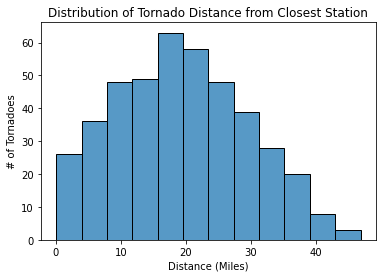

In [73]:
# plot the distribution of the distance of each tornado event from it's closest weather station
sns.histplot(data=tornado_data['DISTANCE_MILES'])
plt.xlabel('Distance (Miles)')
plt.ylabel('# of Tornadoes')
plt.title('Distribution of Tornado Distance from Closest Station')

In [74]:
# look at frequency of tornado strengths on F-scale
tornado_data['TOR_F_SCALE'].value_counts().sort_index()

EF0    122
EF1    229
EF2     59
EF3     10
EF4      6
Name: TOR_F_SCALE, dtype: int64

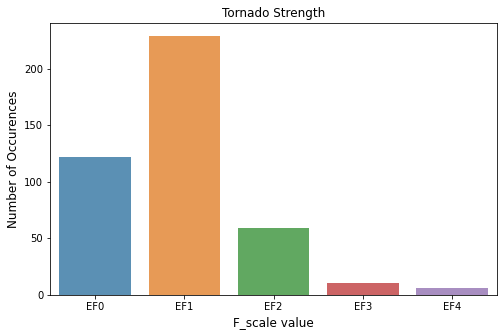

In [75]:
# create bar chart of the tornado f_scale value counts
f_scale = tornado_data['TOR_F_SCALE'].value_counts().sort_index()
plt.figure(figsize=(8,5))
sns.barplot(x=f_scale.index, y=f_scale.values, alpha=0.8)
plt.title('Tornado Strength')
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('F_scale value', fontsize=12)
plt.show()

The most common strength of storms is EF1, which is a storm with winds of 86-110 mph. As storm strength increases, the frequency of their occurrence decreases. The f_scale goes up to EF5, but no such storms were reported in this time frame.

# Downsizing Data

Let's now look to create a new data set, in which we include all of the rows with tornadoes, but only some of the non-tornado rows. There are 426 rows containing a tornado event, and I want there to be a 4:1 ratio between non-tornado and tornado data, so we can randomly select 1704 rows from the non-tornado rows to remain in this new set of data.

In [76]:
# get a sample of 1704 rows that didn't have tornado events
sample = tornado_data.loc[tornado_data['TORNADO'] != 1].sample(n=1704, random_state=100)

In [77]:
sample.shape

(1704, 61)

In [78]:
# filter all rows with tornadoes
sample_t = tornado_data.loc[tornado_data['TORNADO'] == 1]

In [79]:
sample_t.shape

(426, 61)

In [80]:
# combine above two dataframes into 1
downsized = pd.concat([sample, sample_t], axis=0).reset_index()

In [81]:
downsized.shape

(2130, 62)

# Analyzing Downsized Data

Let's look at some scatter plots of the features, color-coded based on whether or not a tornado occurred.

Text(0.5, 1.0, 'Max Wind Speed vs. Temperature')

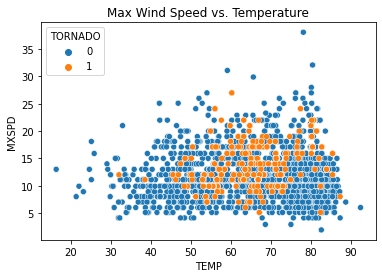

In [82]:
# scatter plot of MXSPD and TEMP sorted by Tornado occurrence
sns.scatterplot(x=downsized['TEMP'], y=downsized['MXSPD'], hue=downsized['TORNADO'])
plt.title('Max Wind Speed vs. Temperature')

Text(0.5, 1.0, 'Maximum Temperature vs. Atmospheric Pressure')

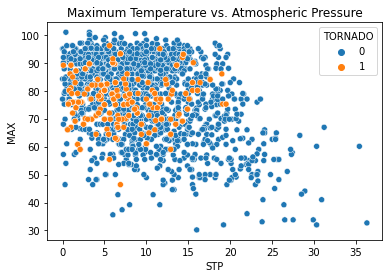

In [83]:
# scatter plot of STP and MAX sorted by Tornado occurrence
sns.scatterplot(x=downsized['STP'], y=downsized['MAX'], hue=downsized['TORNADO'])
plt.title('Maximum Temperature vs. Atmospheric Pressure')

Text(0.5, 1.0, 'Average Wind Speed vs. Visibility')

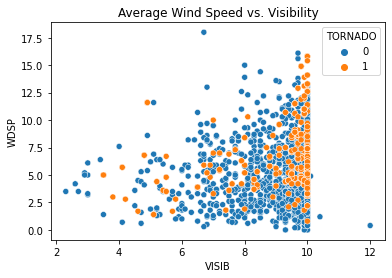

In [84]:
# scatter plot of VISIB and WDSP sorted by Tornado occurrence
sns.scatterplot(x=downsized['VISIB'], y=downsized['WDSP'], hue=downsized['TORNADO'])
plt.title('Average Wind Speed vs. Visibility')

Text(0.5, 1.0, 'Temperature vs. Dew Point')

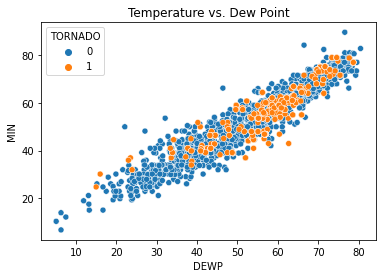

In [85]:
# scatter plot of DEWP and MIN sorted by Tornado occurrence
sns.scatterplot(x=downsized['DEWP'], y=downsized['MIN'], hue=downsized['TORNADO'])
plt.title('Temperature vs. Dew Point')

In [86]:
downsized.to_csv('/Users/gregoryolson/Documents/Data Science CT/Capstone/Capstone_Tornado/Data/tornado_downsized.csv')